In [1]:
# Imports
import contextily as cx 
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import NearestNeighbors

# Inverse distance weighted interpolation

### Read and prepare data

In [2]:
# Read data from .csv file, drop apartments without location data
df = pd.read_csv("data/boligzonen.csv")
df = df[df.longitude != 0.0]
df.head()

,id,rooms,area,rent,norm_rent,latitude,longitude
0,5248131,1,38,5216,137.26,55.652406,12.512200
1,5275700,1,37,7900,213.51,55.671065,12.501394
2,5211187,1,40,6300,157.50,55.649554,12.551497
3,5263181,3,73,11000,150.68,55.663465,12.542260
4,5249720,3,73,11000,150.68,55.663465,12.542260


In [5]:
# Create GeoDataFrame from Pandas DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
gdf.head()

,id,rooms,area,rent,norm_rent,latitude,longitude,geometry
0,5248131,1,38,5216,137.26,55.652406,12.512200,POINT (12.51220 55.65241)
1,5275700,1,37,7900,213.51,55.671065,12.501394,POINT (12.50139 55.67106)
2,5211187,1,40,6300,157.50,55.649554,12.551497,POINT (12.55150 55.64955)
3,5263181,3,73,11000,150.68,55.663465,12.542260,POINT (12.54226 55.66347)
4,5249720,3,73,11000,150.68,55.663465,12.542260,POINT (12.54226 55.66347)


### Grid for interpolation

In [7]:
# Borders of the grid for interpolation
lon_min, lat_min, lon_max, lat_max = gdf.geometry.total_bounds
print(f"lon: {lon_max}-{lon_min}, lat: {lat_max}-{lat_min}")

lon: 12.642434-12.433844, lat: 55.743446-55.606455


In [8]:
# Grid density
D = 10

# Number of nearest neighbors
K = 10

# Power parameter for IDW
P = 1

In [9]:
# Create grid of points
x = np.linspace(lon_min, 12.657, 5*D)
y = np.linspace(lat_min, lat_max, 4*D)
x, y = np.meshgrid(x, y)
grid = np.column_stack((x.ravel(), y.ravel()))

In [10]:
# Create grid DataFrame and GeoDataFrame 
grid_df = pd.DataFrame(grid, columns=['longitude', 'latitude'])
grid_gdf = gpd.GeoDataFrame(grid_df, geometry=gpd.points_from_xy(grid_df.longitude, grid_df.latitude), crs="EPSG:4326")
grid_gdf.head()

,longitude,latitude,geometry
0,12.433844,55.606455,POINT (12.43384 55.60645)
1,12.438398,55.606455,POINT (12.43840 55.60645)
2,12.442952,55.606455,POINT (12.44295 55.60645)
3,12.447507,55.606455,POINT (12.44751 55.60645)
4,12.452061,55.606455,POINT (12.45206 55.60645)


### Find nearest neighbors

In [12]:
# Put apartment coordinates into numpy array
apartments = np.array([[row.longitude, row.latitude] for index, row in df.iterrows()])

# Put grid point coordinates into numpy array
grid = np.array(grid)

# Fit apartment coordinates into nearest neighbors
nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(apartments)

# Find k nearest neighbors - k nearest apartments to grid points
distances, indices = nbrs.kneighbors(grid)

# Get unique set of neighbors
unique_indices = set(indices.flatten())
neighbors = gdf[gdf.index.isin(unique_indices)].copy()

In [13]:
# Visualise grid points and its neighbors
fig, ax = plt.subplots(figsize=(10, 10))
neighbors.plot(ax=ax, color='blue')
grid_gdf.plot(ax=ax, color='black')
ax.legend(['Apartments', 'Grid'], loc='upper right')
cx.add_basemap(ax, crs=gdf.crs)
plt.show()

In [14]:
indices

array([[1296,  861,  252, ..., 1796,  796,  310],
       [1296,  861,  252, ..., 1796,  796,  310],
       [1296,  861,  252, ..., 1796,  796,  310],
       ...,
       [   8,  248,  590, ...,  804,  296,  834],
       [   8,  248,  590, ...,   78,  804,   42],
       [   8,  296,  248, ...,  192,  390,   10]])

### Formula for IDW interpolation

$$
z_p = 
\frac{
        \sum_{i=1}^{n}
        \big( 
            \frac{z_i}{{d_i}^p}
        \big)
    }
    {
        \sum_{i=1}^{n}
        \big( 
            \frac{1}{{d_i}^p}
        \big)
    }
$$

$$
z_p - \text{interpolated value with a given power p} \\
z_i - \text{value at known point i} \\
d_i - \text{distance to the known point i} \\
p - \text{power}
$$
source:
https://gisgeography.com/inverse-distance-weighting-idw-interpolation/

In [15]:
# Interpolate value of normalised rent over grid of points
interpolated_rent = []
for i, d in zip(indices, distances):
    rent = [df.iloc[_].rent for _ in i]
    numerator = rent / (d**P)
    denominator = 1 / (d**P)
    interpolated_rent.append(sum(numerator) / sum(denominator))

In [16]:
# Add interpolated values as a new column of the existing DataFrame
grid_gdf["interpolated_rent"] = interpolated_rent

In [17]:
# Convert dataframe columns into arrays
longitude = grid_df["longitude"].values
latitude = grid_df["latitude"].values
interpolated_rent = grid_df["interpolated_rent"].values

In [26]:
# Reshape 1D array into 2D array
grid = np.reshape(interpolated_rent, (4*D, 5*D))
grid

array([[ 9602.62758028,  9602.00954781,  9601.31553719, ...,
         7321.87667783,  7585.34261329,  7845.51120013],
       [ 9602.97700163,  9602.30300463,  9601.53433302, ...,
         7321.74787225,  7826.62289336,  7834.54997422],
       [ 9603.38954392,  9602.65424895,  9601.79984196, ...,
         7551.97998273,  7809.89855442,  7821.96773387],
       ...,
       [16369.1569253 , 16473.32323908, 15311.51625012, ...,
        16253.98432767, 15749.2008273 , 15741.38836305],
       [16369.24497596, 16473.50173655, 13352.18800148, ...,
        16006.03244829, 15761.19328158, 15752.90174949],
       [16369.31637638, 15248.99175298, 12963.69808936, ...,
        16561.49247555, 16008.90942514, 15763.3171834 ]])

In [19]:
neighbors.head()

,id,rooms,area,rent,norm_rent,latitude,longitude,geometry
0,5248131,1,38,5216,137.26,55.652406,12.512200,POINT (12.51220 55.65241)
1,5275700,1,37,7900,213.51,55.671065,12.501394,POINT (12.50139 55.67106)
2,5211187,1,40,6300,157.50,55.649554,12.551497,POINT (12.55150 55.64955)
3,5263181,3,73,11000,150.68,55.663465,12.542260,POINT (12.54226 55.66347)
4,5249720,3,73,11000,150.68,55.663465,12.542260,POINT (12.54226 55.66347)


In [22]:
# Read polygons with Copenhagen areas
bydel = gpd.read_file("data/bydel.geojson")

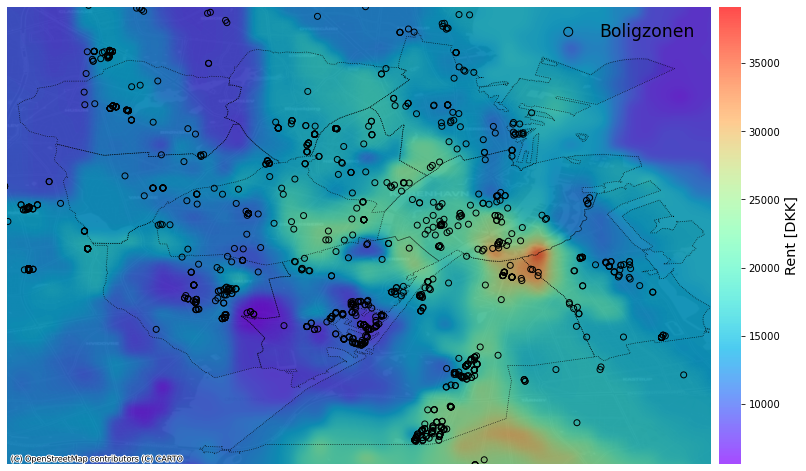

In [31]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

# Plot Copenhagen areas
bydel.plot(ax=ax, facecolor='none', edgecolor='black', linestyle='dotted', lw=0.7)

# Add the basemap using contextily
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.CartoDB.DarkMatter, alpha=0.85)

# Scatter plot of neighbors
sc = ax.scatter(neighbors.longitude, neighbors.latitude, facecolors='none', edgecolors='black')

# Plot the interpolation grid using imshow with transparency
im = ax.imshow(grid, extent=(lon_min, 12.657, lat_min, lat_max), cmap='rainbow', interpolation='gaussian', alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(im, shrink=0.84, pad=0.01)
cbar.set_label('Rent [DKK]', fontsize='x-large', labelpad=5)
cbar.outline.set_visible(False)

# Add legend
ax.legend(['Boligzonen'], loc='upper right', markerscale=1.5, fontsize='xx-large', labelcolor='black', frameon=False)

# Set limit on longitude and latitude - isolate the cluster
ax.set_ylim(55.61, 55.74)
ax.set_xlim(12.45, 12.65)

# Remove longitude and latitude 
ax.set_axis_off()

# Save plot
plt.savefig(f"plots/rent_apartments_D-{D}_K-{K}_P-{P}.png", dpi=600) 

# Show the plot
plt.show()

# Release resources
plt.close()